<a href="https://colab.research.google.com/github/ShengruiLYU/MOSEI_UMONS/blob/master/Visual%20Modality%20II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Modality: Video Network

Used pytorch pretrained R(2+1)-18 model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install av
!mkdir data/
!unzip drive/My\ Drive/subsetVideo.zip -d data/
!unzip drive/My\ Drive/data_mosei.zip -d data/

## Get features and labels

In [3]:
import torch
import torchvision
import glob
import numpy as np

In [4]:
# load model
torch.cuda.empty_cache()
model = torchvision.models.video.r2plus1d_18(pretrained=True).cuda()

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth


In [4]:
# grab a video sample
video_frames, _, metadata = torchvision.io.read_video('data/subsetVideo/0OXeN3MhFeA_16.mp4', pts_unit='sec')

In [56]:
video_frames.shape # T x H x W x C

torch.Size([41, 720, 1280, 3])

In [57]:
metadata

{'audio_fps': 44100, 'video_fps': 30.0}

In [6]:
# source: https://github.com/pytorch/vision/blob/master/references/video_classification/transforms.py
# exclusive transforms for processing videos
from transforms import ToFloatTensorInZeroOne, Resize, CenterCrop, Normalize

transform = torchvision.transforms.Compose([
    ToFloatTensorInZeroOne(),
    Resize(112),
    CenterCrop((112, 112)),
    Normalize(
        mean=[0.43216, 0.394666, 0.37645],
        std=[0.22803, 0.22145, 0.216989]
    )
])

In [7]:
transformed_video = transform(video_frames).unsqueeze(0).cuda()
transformed_video.shape # batch_size x channel x time x height x width

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([1, 3, 41, 112, 112])

In [62]:
features = model(transformed_video)
features.shape

torch.Size([1, 400])

In [ ]:
# get features for videos
all_features = []
video_ids = []

for video_path in glob.glob('data/subsetVideo/*.mp4'):
    frames, _, _ = torchvision.io.read_video(video_path, pts_unit='sec')
    num_frames = frames.shape[0]
    if num_frames == 0 or num_frames > 150:
        continue # only get videos of 0~5s to avoid OOM (actual usage ~15G)

    model_input = transform(frames).unsqueeze(0).cuda()
    features = model(model_input).detach().cpu().numpy()
    all_features.append(features)
    video_ids.append(video_path.split('/')[-1])
    print('video {}: {} frames'.format(len(all_features), num_frames))

all_features = np.array(all_features)

In [13]:
len(video_ids)

780

In [43]:
# get labels
import pickle
import os

dataroot = 'data'
y_train_file = os.path.join(dataroot, "Y_S_train.pkl")
y_valid_file = os.path.join(dataroot, "Y_S_valid.pkl")
y_test_file = os.path.join(dataroot, "Y_S_test.pkl")
key_to_sentiment_train = pickle.load(open(y_train_file, "rb"))
key_to_sentiment_valid = pickle.load(open(y_valid_file, "rb"))
key_to_sentiment_test = pickle.load(open(y_test_file, "rb"))

In [53]:
labels = []

for video_id in video_ids:
    video_id = video_id.split('.')[0]
    idx = video_id.rfind("_")
    key = video_id[:idx] + '[' + video_id[idx+1:] + ']'
    label = key_to_sentiment_train.get(key, None) or \
            key_to_sentiment_valid.get(key, None) or \
            key_to_sentiment_test.get(key, None)
    labels.append(label)

labels = np.array(labels)

In [59]:
print('label hit rate = {}'.format((labels != None).sum() / len(labels)))

label hit rate = 0.391025641025641


In [63]:
[video_ids[int(idx)] for idx in np.argwhere(labels != None)[:30]]

['gR4gM_WXesQ_3.mp4',
 '273171_14.mp4',
 'XrNaL-MTjXg_4.mp4',
 'huzEsVEJPaY_0.mp4',
 '24196_17.mp4',
 '108146_1.mp4',
 'oHV99Y_EWfI_1.mp4',
 '215259_7.mp4',
 'j0br-fFy160_1.mp4',
 '267278_22.mp4',
 'bfy28AlY-TQ_0.mp4',
 '267799_2.mp4',
 'bVhWpCvpSs4_4.mp4',
 'SWHmteF5Rlk_7.mp4',
 '35694_10.mp4',
 'asWraTfIqq0_6.mp4',
 'WgI8IbJtXHw_1.mp4',
 'DdUJojoFU_c_6.mp4',
 'J3-NEG8uoiE_8.mp4',
 '167521_9.mp4',
 'fVCDn6SdtVM_0.mp4',
 '4qoB5a6dR3w_0.mp4',
 'R9ypacCuEZo_5.mp4',
 'TVhXqAI9gyA_1.mp4',
 'kPch8YhNfPE_2.mp4',
 'JLqBVj6f5gI_11.mp4',
 'avW2m6VHTyg_7.mp4',
 'gZDyk95Xob4_4.mp4',
 'HLFaW4oVP9E_6.mp4',
 '69824_3.mp4']

## Visualization

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [47]:
all_features.shape

(780, 1, 400)

In [48]:
# t-sne embeddings
all_features_squeezed = all_features.reshape(-1, 400)
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne_model.fit_transform(all_features_squeezed)
X_embedded.shape

(780, 2)

In [49]:
filtered_labels = labels[labels != None]
filtered_embeddings = X_embedded[labels != None]

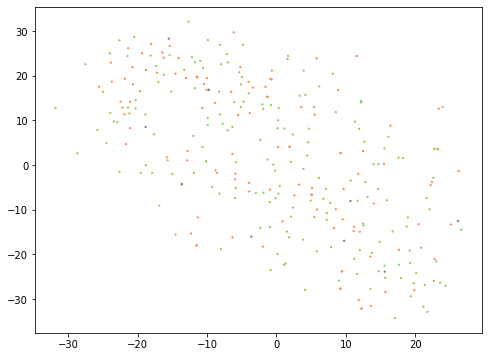

In [52]:
color_labels = []
for l in filtered_labels:
  if l > 0:
    color_labels.append('#91cf60')
  elif l < 0:
    color_labels.append('#fc8d59')
  else:
    color_labels.append('grey')

plt.figure(figsize=(8, 6))
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=color_labels, s=1.5)